<a href="https://colab.research.google.com/github/Zakaria-bls/data-science-project/blob/main/Two%20algorithms%20(meduim%20data)%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:73: SyntaxWarning: invalid escape sequence '\s'
<>:73: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-4063830235.py:73: SyntaxWarning: invalid escape sequence '\s'
  sep=',\s*',


Spark session déjà active.

--- 📥 Chargement et Nettoyage du Dataset Adult ---
Dataset Adult chargé et converti en Spark DataFrame. ✅
Nombre de lignes après nettoyage: 32561

--- 🛠️ Prétraitement des Données (Pipeline PySpark) ---
Dataset prêt pour le K-Means. Nombre de dimensions: 108

--- 🏃 Exécution du K-Means Spark ---
Adult Dataset (K=2): Temps=13.88s, Inertie=3390461.34, Silhouette=0.0637
Adult Dataset (K=3): Temps=8.87s, Inertie=3356520.39, Silhouette=0.0668
Adult Dataset (K=4): Temps=7.93s, Inertie=3290284.30, Silhouette=0.0710
Adult Dataset (K=5): Temps=5.35s, Inertie=3286212.39, Silhouette=0.0624

Résultats K-Means Spark pour le Dataset Adult:
   k       time       inertia  silhouette
0  2  13.884858  3.390461e+06    0.063691
1  3   8.868725  3.356520e+06    0.066806
2  4   7.925051  3.290284e+06    0.070993
3  5   5.345704  3.286212e+06    0.062419

--- 📊 Visualisation des Clusters (PCA) ---


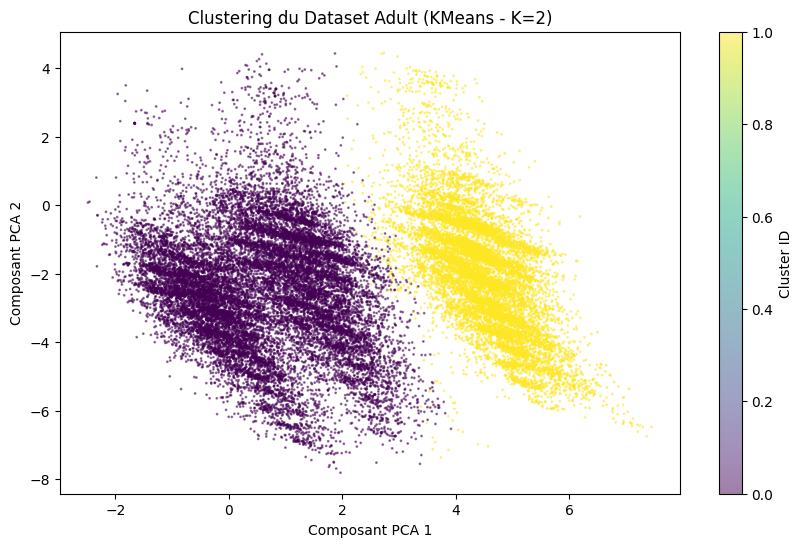


Spark session stopped.


In [ ]:
# =================================================================
# 1. SETUP & IMPORTS
# =================================================================

from pyspark.sql import SparkSession
import pandas as pd
import time
from pyspark.ml.feature import VectorAssembler, PCA, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col

# Initialisation de la session Spark
if 'spark' not in locals():
    spark = SparkSession.builder.appName("Clustering_Adult_Data").getOrCreate()
    print("Spark OK ✅")
else:
    print("Spark session déjà active.")


# =================================================================
# 2. FONCTION K-MEANS SPARK (Réutilisée)
# =================================================================

def run_kmeans_spark(df, k):
    """Exécute l'algorithme K-Means de Spark sur le DataFrame vectorisé."""
    t0 = time.perf_counter()

    # Création et entraînement du modèle
    kmeans = SparkKMeans(k=k, seed=0, featuresCol="features", predictionCol="prediction")
    model = kmeans.fit(df)
    predictions = model.transform(df)

    t1 = time.perf_counter()

    # Évaluation (Silhouette Score et Inertie)
    evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")
    silhouette = evaluator.evaluate(predictions)
    inertia = model.summary.trainingCost

    return {
        "k": k,
        "time": t1 - t0,
        "inertia": inertia,
        "silhouette": silhouette,
        "predictions": predictions
    }


# =================================================================
# 3. CHARGEMENT ET NETTOYAGE DU DATASET ADULT (Corrigé)
# =================================================================

print("\n--- 📥 Chargement et Nettoyage du Dataset Adult ---")

ADULT_DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
COLUMNS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
    'income'
]

# Chargement sécurisé via Pandas, puis conversion à Spark
try:
    adult_df_pd = pd.read_csv(
        ADULT_DATA_URL,
        header=None,
        names=COLUMNS,
        sep=',\s*',
        na_values='?', # Pandas gère '?' comme NaN
        engine='python'
    )
    # Conversion Pandas -> Spark
    adult_df_spark = spark.createDataFrame(adult_df_pd)
    print("Dataset Adult chargé et converti en Spark DataFrame. ✅")
except Exception as e:
    print(f"Erreur de chargement: {e}")
    spark.stop()
    raise

# Nettoyage : Suppression des lignes avec des valeurs manquantes (NaN en Pandas -> NULL en Spark)
adult_df_cleaned = adult_df_spark.na.drop()
print(f"Nombre de lignes après nettoyage: {adult_df_cleaned.count()}")


# =================================================================
# 4. PRÉTRAITEMENT AVEC PIPELINE PYSPARK
# =================================================================

print("\n--- 🛠️ Prétraitement des Données (Pipeline PySpark) ---")

# Séparation des types de colonnes
feature_cols = [c for c in adult_df_cleaned.columns if c not in ['income']]
categorical_features = [c for c in feature_cols if adult_df_cleaned.schema[c].dataType.simpleString() == 'string']
numerical_features = [c for c in feature_cols if adult_df_cleaned.schema[c].dataType.simpleString() != 'string']

# --- A. Pipeline pour les Catégories (StringIndexer + OneHotEncoder) ---
indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_indexed", handleInvalid='keep') for c in categorical_features
]

encoders = [
    OneHotEncoder(inputCol=c + "_indexed", outputCol=c + "_vec") for c in categorical_features
]

encoded_features = [c + "_vec" for c in categorical_features]

# --- B. Assemblage (VectorAssembler) ---
assembler_final = VectorAssembler(
    inputCols=numerical_features + encoded_features,
    outputCol="raw_features"
)

# --- C. Mise à l'Échelle (StandardScaler) ---
scaler = StandardScaler(inputCol="raw_features", outputCol="features",
                        withStd=True, withMean=False)

# Définition du Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler_final, scaler])

# Ajustement (fit) et Transformation (transform) des données
pipeline_model = pipeline.fit(adult_df_cleaned)
adult_spark_vectorized = pipeline_model.transform(adult_df_cleaned).select("features")

print(f"Dataset prêt pour le K-Means. Nombre de dimensions: {len(adult_spark_vectorized.first()[0])}")


# =================================================================
# 5. EXÉCUTION ET RÉSULTATS K-MEANS SPARK
# =================================================================

k_values_spark = [2, 3, 4, 5]
results_adult_spark = []
predictions_spark_adult = None

print("\n--- 🏃 Exécution du K-Means Spark ---")

for k in k_values_spark:
    r = run_kmeans_spark(adult_spark_vectorized, k)
    if k == 2:
        predictions_spark_adult = r["predictions"]
    del r["predictions"]
    results_adult_spark.append(r)
    print(f"Adult Dataset (K={k}): Temps={r['time']:.2f}s, Inertie={r['inertia']:.2f}, Silhouette={r['silhouette']:.4f}")

# Résumé des Résultats
df_results_spark_adult = pd.DataFrame(results_adult_spark)
print("\nRésultats K-Means Spark pour le Dataset Adult:")
print(df_results_spark_adult)


# =================================================================
# 6. RÉDUCTION DE DIMENSION (PCA) ET VISUALISATION (k=2)
# =================================================================

print("\n--- 📊 Visualisation des Clusters (PCA) ---")

# Réduction des dimensions à 2D avec PCA
pca_adult = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model_adult = pca_adult.fit(adult_spark_vectorized)
df_adult_pca = pca_model_adult.transform(adult_spark_vectorized)

# Jointure avec les prédictions (pour k=2)
df_adult_pca_with_preds = df_adult_pca.join(predictions_spark_adult, on=["features"])

# Conversion en Pandas DataFrame pour Matplotlib
adult_pca_pd = df_adult_pca_with_preds.select("prediction", "pca_features").toPandas()
adult_pca_pd['PCA_1'] = adult_pca_pd['pca_features'].apply(lambda x: x[0])
adult_pca_pd['PCA_2'] = adult_pca_pd['pca_features'].apply(lambda x: x[1])

# Plotting the clusters for Adult Dataset (K=2)
plt.figure(figsize=(10, 6))
plt.scatter(adult_pca_pd['PCA_1'], adult_pca_pd['PCA_2'], c=adult_pca_pd['prediction'], cmap='viridis', alpha=0.5, s=1)
plt.title("Clustering du Dataset Adult (KMeans - K=2)")
plt.xlabel("Composant PCA 1")
plt.ylabel("Composant PCA 2")
plt.colorbar(label="Cluster ID")
plt.show()

# Arrêter la session Spark
spark.stop()
print("\nSpark session stopped.")

<>:51: SyntaxWarning: invalid escape sequence '\s'
<>:51: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2521672908.py:51: SyntaxWarning: invalid escape sequence '\s'
  sep=',\s*',


--- 🧠 Début du Prétraitement du Dataset Adult ---
Dataset nettoyé : 30162 lignes.
Dimensions après One-Hot Encoding : (30162, 96)

--- 🚀 Exécution de K-Means (Scikit-learn) ---
k=2: Temps=2.18s, Inertie=2815704.63, Silhouette=0.0501
k=3: Temps=2.87s, Inertie=2769863.45, Silhouette=0.0363
k=4: Temps=1.91s, Inertie=2726888.63, Silhouette=0.0346
k=5: Temps=2.16s, Inertie=2681870.28, Silhouette=0.0465

Résultats K-Means Scikit-learn (Adult):
   k      time       inertia  silhouette  \
0  2  2.176786  2.815705e+06    0.050054   
1  3  2.873467  2.769863e+06    0.036284   
2  4  1.909962  2.726889e+06    0.034567   
3  5  2.155389  2.681870e+06    0.046466   

                                              labels  
0  [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, ...  
1  [2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 0, 2, 1, 1, ...  
2  [1, 3, 1, 2, 2, 3, 2, 3, 1, 3, 2, 2, 1, 2, 3, ...  
3  [3, 3, 4, 4, 3, 3, 2, 4, 3, 3, 4, 1, 2, 2, 4, ...  

--- 📊 Génération de la Visualisation ---


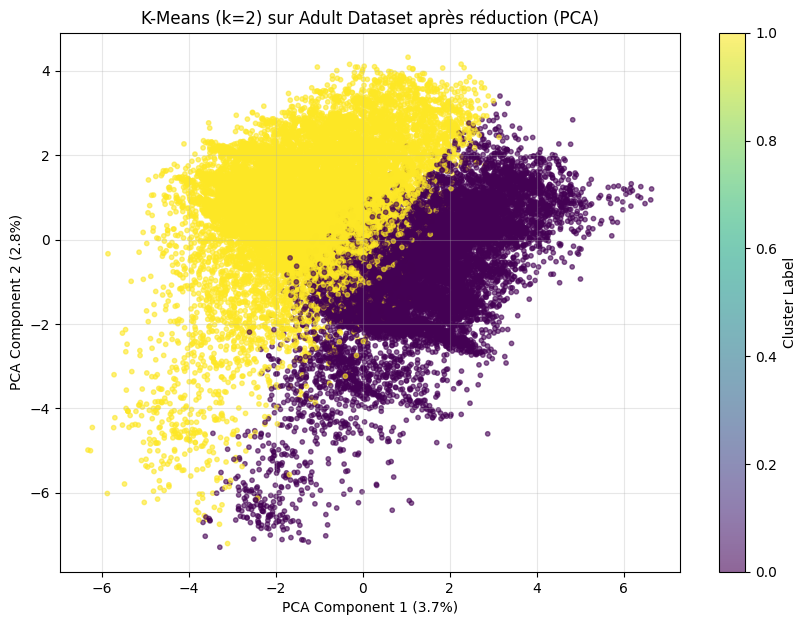

Variance expliquée par les 2 composantes PCA : 6.53%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.cluster import KMeans as SkKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# =================================================================
# 1. Fonction KMeans scikit-learn
# =================================================================

def run_kmeans_sklearn(X, k):
    """Exécute l'algorithme K-Means de Scikit-learn et retourne les métriques."""
    t0 = time.perf_counter()
    # Configuration standard pour le K-Means
    km = SkKMeans(n_clusters=k, n_init=10, max_iter=300, random_state=0)
    labels = km.fit_predict(X)
    t1 = time.perf_counter()
    return {
        "k": k,
        "time": t1 - t0,
        "inertia": km.inertia_,
        # Calcul du Silhouette Score (peut être long sur ce dataset)
        "silhouette": silhouette_score(X, labels),
        "labels": labels
    }

# =================================================================
# 2. Chargement et Prétraitement du Dataset Adult
# =================================================================

print("--- 🧠 Début du Prétraitement du Dataset Adult ---")

COLUMNS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
    'income'
]

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Chargement, traitement des valeurs manquantes ('?') et séparation par virgule + espaces
adult = pd.read_csv(
    data_url,
    header=None,
    names=COLUMNS,
    sep=',\s*',
    na_values='?',
    engine='python'
)

# Nettoyage : Suppression des lignes avec valeurs manquantes (NaN)
adult = adult.dropna()
X_adult = adult.drop('income', axis=1)

print(f"Dataset nettoyé : {len(adult)} lignes.")

# Encodage des variables catégorielles (One-Hot Encoding)
categorical_features = X_adult.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X_adult, columns=categorical_features, drop_first=True)

print(f"Dimensions après One-Hot Encoding : {X_encoded.shape}")

# Mise à l'Échelle (StandardScaler)
scaler = StandardScaler()
X_adult_scaled_array = scaler.fit_transform(X_encoded)

# Création du DataFrame final pour le clustering
X_adult_scaled = pd.DataFrame(
    X_adult_scaled_array,
    columns=X_encoded.columns,
    index=X_encoded.index
)

# =================================================================
# 3. Exécution de K-Means (Scikit-learn)
# =================================================================

k_values_adult = [2, 3, 4, 5]
results_adult_sklearn = []

print("\n--- 🚀 Exécution de K-Means (Scikit-learn) ---")

for k in k_values_adult:
    # Utilisation de X_adult_scaled pour l'entraînement
    res = run_kmeans_sklearn(X_adult_scaled, k)
    results_adult_sklearn.append(res)

    print(f"k={k}: Temps={res['time']:.2f}s, Inertie={res['inertia']:.2f}, Silhouette={res['silhouette']:.4f}")

df_results_adult_sklearn = pd.DataFrame(results_adult_sklearn)
print("\nRésultats K-Means Scikit-learn (Adult):")
print(df_results_adult_sklearn)
df_results_adult_sklearn.to_csv("results_adult_sklearn.csv", index=False)


# =================================================================
# 4. Réduction de Dimension (PCA) et Visualisation (k=2)
# =================================================================

print("\n--- 📊 Génération de la Visualisation ---")

# 1. Réduction de dimension (de 100+ dimensions à 2D)
pca = PCA(n_components=2, random_state=0)
X_adult_2d = pca.fit_transform(X_adult_scaled)

# Récupérer les labels pour k=2
labels_adult_k2 = df_results_adult_sklearn[df_results_adult_sklearn['k'] == 2]['labels'].iloc[0]

# 2. Visualisation des clusters
plt.figure(figsize=(10, 7))
plt.scatter(
    X_adult_2d[:, 0],
    X_adult_2d[:, 1],
    c=labels_adult_k2,
    cmap="viridis",
    alpha=0.6,
    s=10
)
plt.title("K-Means (k=2) sur Adult Dataset après réduction (PCA)")
plt.xlabel(f"PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.colorbar(label="Cluster Label")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Variance expliquée par les 2 composantes PCA : {pca.explained_variance_ratio_.sum()*100:.2f}%")